# Experiments: Model based on U-Net - Trained on Azure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


### Helper methods

## Load Model Weights From Azure Instance

### Experiment 10 - VGG, ImageNet Weights, 128x128

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

Segmentation Models: using `tf.keras` framework.


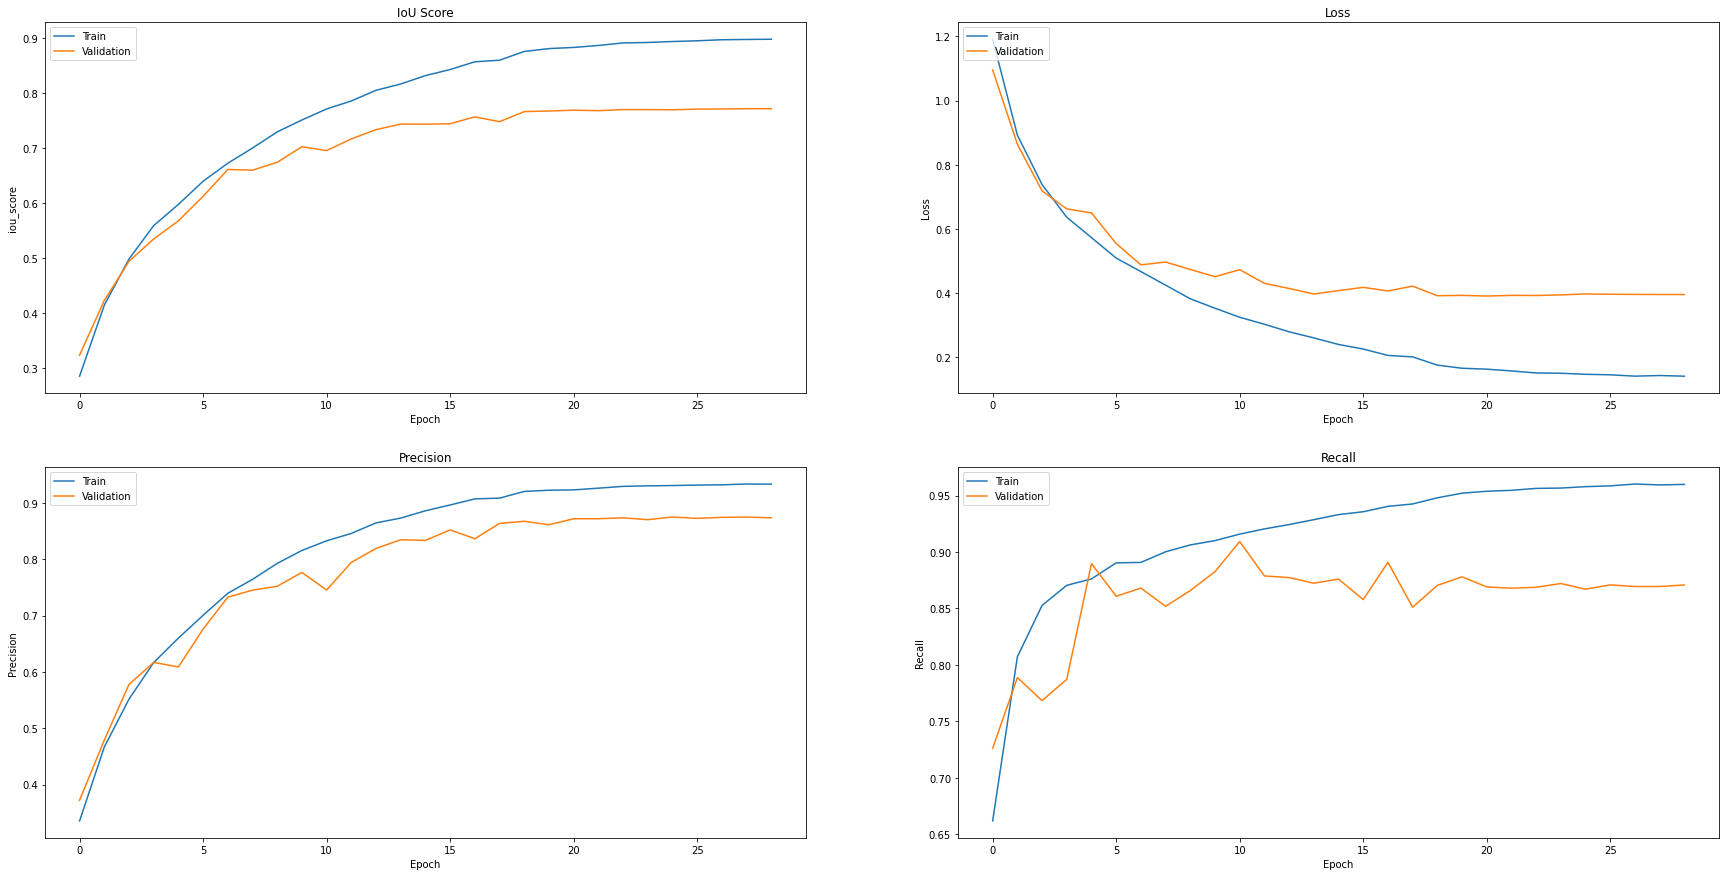

In [3]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_17_2340", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_10_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [4]:
from baseline.trainer import Trainer
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_10_weights_only.h5"))
trainer = Trainer(model=azure_model)

In [5]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


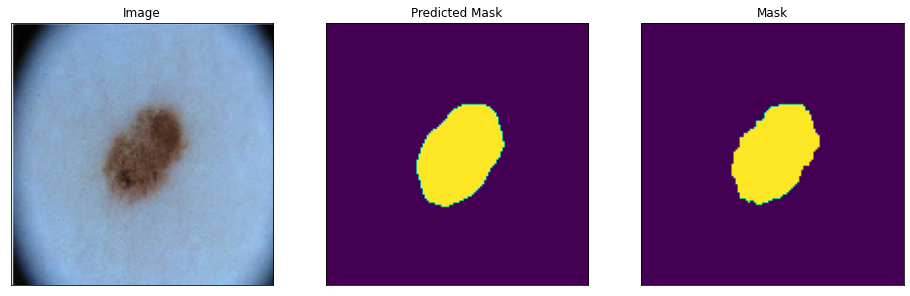

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


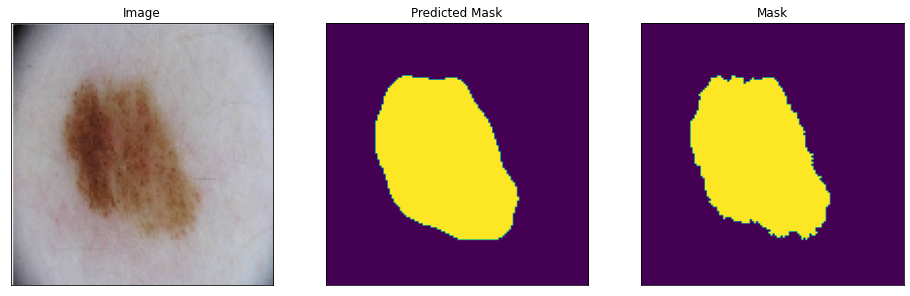

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


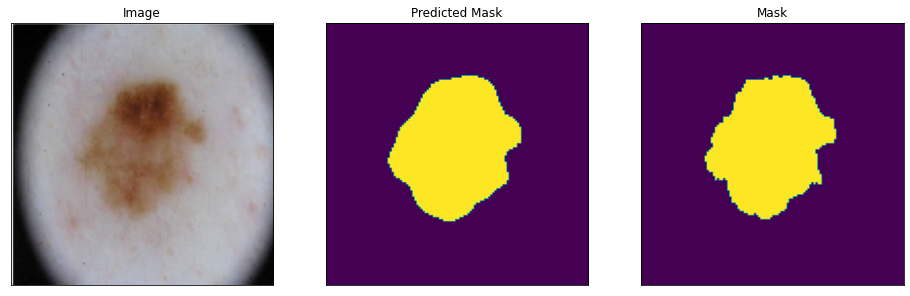

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


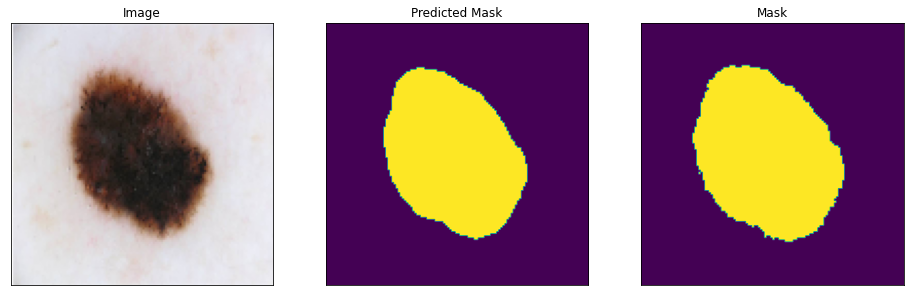

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


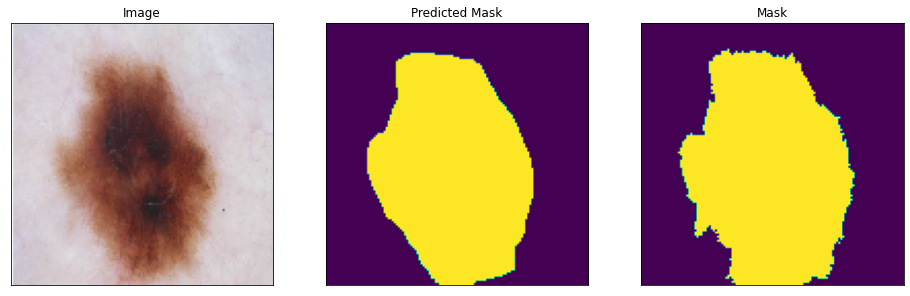

In [6]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [7]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))

In [8]:
import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1)

In [9]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 15.9 s, sys: 164 ms, total: 16.1 s
Wall time: 16.5 s


{'n_images': 300,
 'n_true_positives': 1021645,
 'n_true_negatives': 3687472,
 'n_false_positives': 91235,
 'n_false_negatives': 114848,
 'iou_score': 0.8219148897497744,
 'threshold_jaccard_index': 0.7649807612619688,
 'jaccard_similarity_index': 0.8219148897497744,
 'dice': 0.8917741889592693,
 'f1_score': 0.44588709447963465,
 'sensitivity': 0.9103553094606324,
 'specificity': 0.9713861015548235,
 'accuracy': 0.9580723063151042}

#### Full Image Resolution Metrics

In [ ]:
from constants import TEST_DIR

test_images, test_masks = load_images(TEST_DIR, load_masks=True)

In [ ]:
predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert len(predicted_masks.shape) == len(test_masks)
assert predicted_masks.shape[-1] == 1

In [ ]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

### Experiment 10 - VGG, ImageNet Weights, 192x256

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

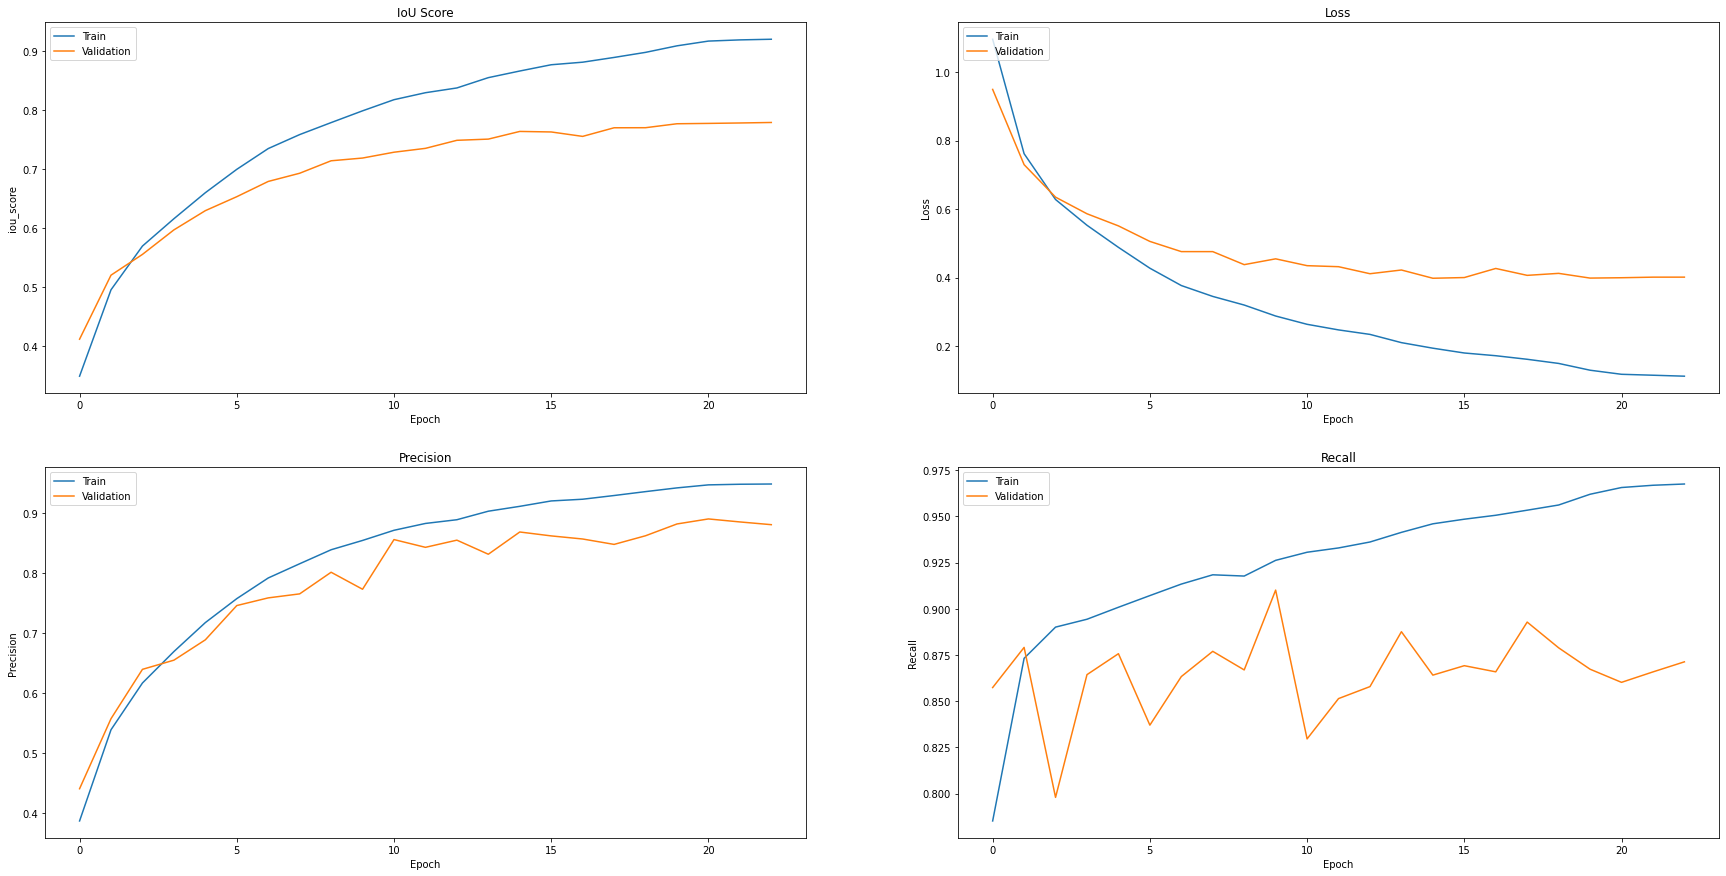

In [10]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_17_2340", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_11_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [11]:
from baseline.trainer import Trainer
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_11_weights_only.h5"))
trainer = Trainer(model=azure_model)

In [13]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(192, 256), size=5)

Image shape: (1, 256, 192, 3)
Predicted mask shape: (1, 256, 192, 1)
Mask shape: (256, 192, 1)


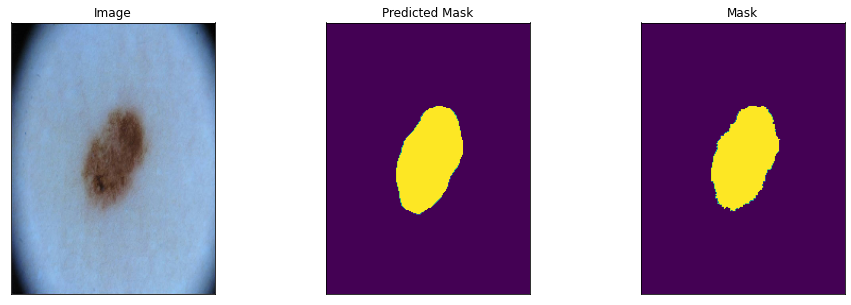

Image shape: (1, 256, 192, 3)
Predicted mask shape: (1, 256, 192, 1)
Mask shape: (256, 192, 1)


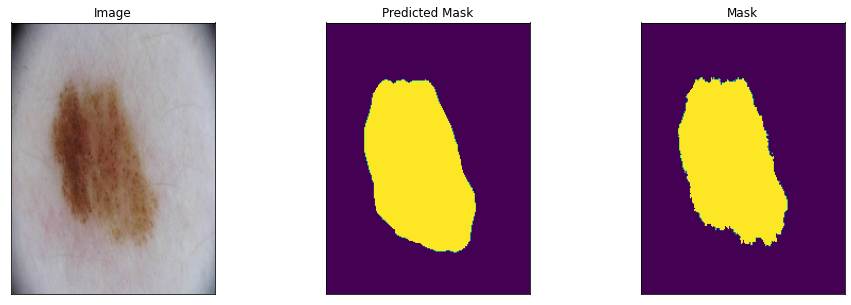

Image shape: (1, 256, 192, 3)
Predicted mask shape: (1, 256, 192, 1)
Mask shape: (256, 192, 1)


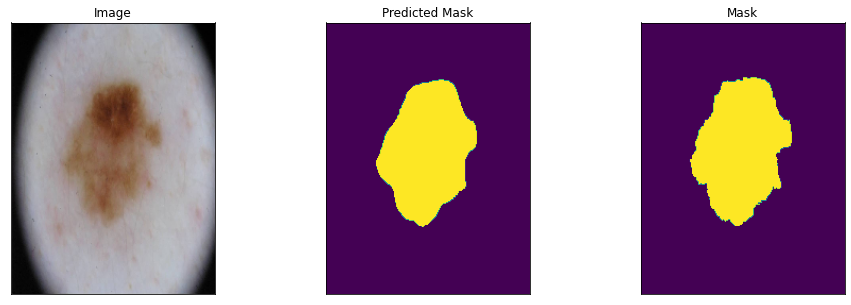

Image shape: (1, 256, 192, 3)
Predicted mask shape: (1, 256, 192, 1)
Mask shape: (256, 192, 1)


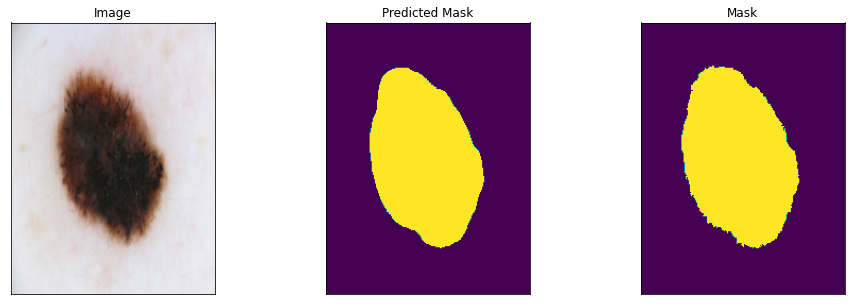

Image shape: (1, 256, 192, 3)
Predicted mask shape: (1, 256, 192, 1)
Mask shape: (256, 192, 1)


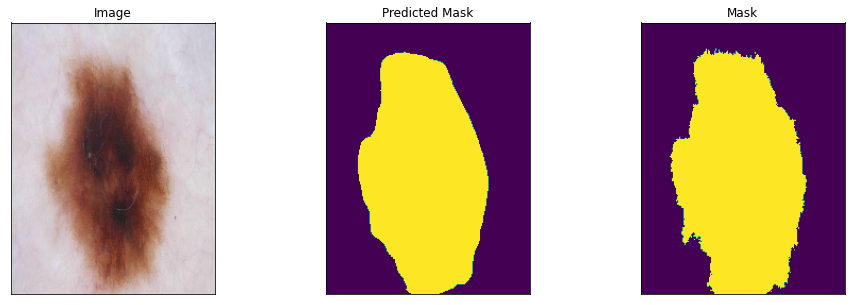

In [14]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [16]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(192, 256))

In [18]:
predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

print(predicted_masks.shape)
assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

(300, 256, 192, 1)


AssertionError: 

In [19]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 41.8 s, sys: 229 ms, total: 42 s
Wall time: 42.4 s


{'n_images': 300,
 'n_true_positives': 3056001,
 'n_true_negatives': 11063306,
 'n_false_positives': 272731,
 'n_false_negatives': 353562,
 'iou_score': 0.8169410767162136,
 'threshold_jaccard_index': 0.7497981563566616,
 'jaccard_similarity_index': 0.8169410767162136,
 'dice': 0.8887316059831437,
 'f1_score': 0.44436580299157186,
 'sensitivity': 0.9013816379988974,
 'specificity': 0.9694716983741962,
 'accuracy': 0.9575267876519096}

#### Full Image Resolution Metrics